In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

PATH = '/home/diederik/ams/pyprojects/pyprojects/data/'
FILE = 'filmdeathcounts.csv'

In [2]:
def clean_cols(df):
        
    df.columns = df.columns.str.lower()
    
    # clean values in columns with np.objects (str)
    for col in df.select_dtypes([np.object]).columns[0:]:
        df.loc[:,(col)] = df.loc[:,(col)].replace('', np.nan).fillna('Unknown')
    df = df.copy()
    return df

In [3]:
df = (pd.read_csv(PATH + FILE)
     .pipe(clean_cols))

df['body_count_pm'] = (df['body_count'].divide(df['length_minutes']))
# get the 25 bloodiest movies where body count per minute is highest
df = df.sort_values(by = ['body_count_pm'], ascending=False)[:25]

In [4]:
# get full titles
title = []
for film, year in zip(df['film'], df['year']):
    title.append(film + " (" + str(year) + ")")
df['title'] = np.array(title)

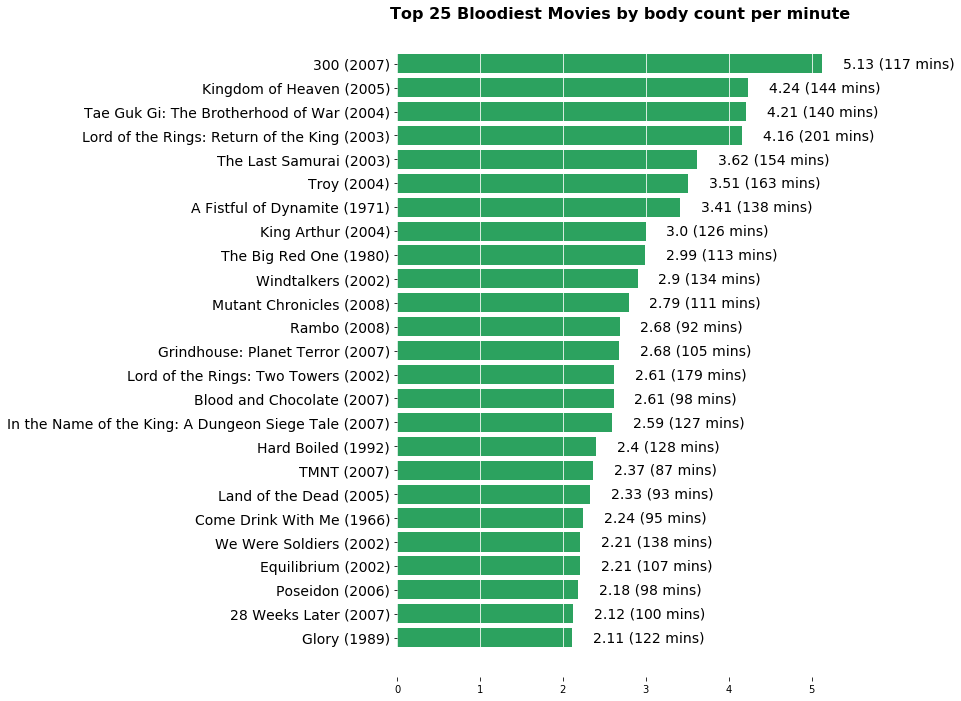

In [9]:
fig, ax = plt.subplots(1,1, figsize= [8,12])

# green horizontal bars
parts = plt.barh(range(len(df["body_count_pm"])),
                    df["body_count_pm"],
                    height=0.8,
                    align="center",
                    color="#2ca25f",
                    edgecolor="none")

# This function adds the body_count_pm label to the right of the bars
# function @ https://github.com/sjmgarnier/R-vs-Python
def autolabel(rects):
    for i, rect in enumerate(rects):
        width = rect.get_width()
        label_text = (str(round(float(width), 2)) +
                        " (" + str(df["length_minutes"].values[i]) +
                        " mins)")
        
        ax.text(width + 0.25,
                    rect.get_y() + rect.get_height() / 2.,
                    label_text,
                    ha="left",
                    va="center",
                    fontsize=14)
       
autolabel(parts)
# reverse order horizontal bars
plt.gca().invert_yaxis()

# get rid of spines
for pos in ['top', 'right', 'left', 'bottom']:
    ax.spines[pos].set_visible(False)

# display titles as ytick labels
ax.set_yticks(np.arange(len(df)))
ax.yaxis.set_ticklabels(df['title'].values, fontsize=14)

# gris and title
ax.xaxis.grid(color="white", linestyle="-")
plt.title("Top 25 Bloodiest Movies by body count per minute", weight="bold", size=16);

In [ ]:
n=2
time_range_freq = '15Min'

# variables
cmap=mpl.cm.RdYlGn_r
vmin = 0
vmax=1000
levels = MaxNLocator(nbins=10).tick_values(vmin, vmax)
labels = [str('{:.0f}'.format(x)) + 's' for x in levels]
norm = mpl.colors.BoundaryNorm(levels, cmap.N, clip=True)

# time range for reeindexing
time_range = pd.date_range(start = '2018-04-20 09:00', end= '2018-04-20 23:45', 
                           freq=time_range_freq).strftime('%H:%M')
time_range = pd.DatetimeIndex(time_range)

fig, ax = plt.subplots(4,1, figsize=[15,25], sharex=False, sharey=False)
plt.subplots_adjust(hspace = .6)
segment_cols = df_day.segment_y.unique().tolist()

subframe = []

for i, col in enumerate(segment_cols):
    sub_df = (df_day.loc[(df_day.segment_y == col), :]
           .groupby('rfid').filter(lambda x: len(x) >= n)
           .groupby(['time','boat_name_hash'])
           .diff_sec.sum()
           .unstack([1]))
    sub_df.index = pd.DatetimeIndex(sub_df.index)
    sub_df = sub_df.resample(time_range_freq).mean().stack().unstack()
    sub_df = sub_df.reindex(time_range)
    
    sub_df = sub_df.dropna(axis=1, how='all')
    
    subframe.append(sub_df)
    
    # color bar magic
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes("right", size="5%", pad=0.05)

    cb = mpl.colorbar.ColorbarBase(cax, cmap=cmap, alpha=.7,
                                norm=None,                                
                                boundaries=levels,
                                ticks=levels,
                                spacing='proportional',
                                orientation='vertical')
    cb._A = []
    cb.set_label('Discrete intervallen sensortijden', size=8)
    cb.set_ticklabels(labels)
    
    #plot
    sns.heatmap(data=subframe[i].T, annot=False, cmap=cmap, ax=ax[i], 
                xticklabels=sub_df.index.strftime('%H:%M'),
                yticklabels=subframe[i].columns, robust=True, cbar=i == cb)
    ax[i].set_title('gemeten sensortijden voor segment: {}'.format(col), pad=20)
    ax[i].set(ylabel='')
    ax[i].set_yticklabels(subframe[i].columns, rotation=0)
    #plt.savefig(PATH_OUTPUT + 'heatmap_sensortijden_segment' + col + '.png')
fig.suptitle('Sensortijden Anne Frank 20 april 2018', y=.92, size=15)
plt.savefig(PATH_OUTPUT + 'heatmap_sensortijden_segment_hashed.png', bbox_inches='tight')